In [79]:
import numpy as np
import os
import pandas as pd
np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

%pylab inline


from collections import OrderedDict

import seaborn as sns
sns.set()

from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_score, recall_score, fbeta_score

import warnings
warnings.simplefilter(action='ignore')

import imblearn.over_sampling

from sklearn.preprocessing import MinMaxScaler, Binarizer, OneHotEncoder, StandardScaler, OrdinalEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


### Load data

In [2]:
app_train = pd.read_csv('app_train.csv', index_col=0)
print(app_train.shape)
app_train.head()

(307511, 247)


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_ANOM
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,637.0,...,0,0,0,0,0,1,0,1,0,False
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,1188.0,...,1,0,0,0,0,0,0,1,0,False
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,225.0,...,0,0,0,0,0,0,0,0,0,False
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,3039.0,...,0,0,0,0,0,0,0,0,0,False
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,3038.0,...,0,0,0,0,0,0,0,0,0,False


#### Add domain features

In [3]:
app_train['CREDIT_INCOME_PERCENT'] = app_train['AMT_CREDIT'] / app_train['AMT_INCOME_TOTAL']
app_train['ANNUITY_INCOME_PERCENT'] = app_train['AMT_ANNUITY'] / app_train['AMT_INCOME_TOTAL']
app_train['CREDIT_TERM'] = app_train['AMT_ANNUITY'] / app_train['AMT_CREDIT']
app_train['DAYS_EMPLOYED_PERCENT'] = app_train['DAYS_EMPLOYED'] / app_train['DAYS_BIRTH']
print(app_train.shape)
app_train.head()

(307511, 251)


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_ANOM,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,637.0,...,0,1,0,1,0,False,2.007889,0.121978,0.060749,-0.067329
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,1188.0,...,0,0,0,1,0,False,4.790750,0.132217,0.027598,-0.070862
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,225.0,...,0,0,0,0,0,False,2.000000,0.100000,0.050000,-0.011814
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,3039.0,...,0,0,0,0,0,False,2.316167,0.219900,0.094941,-0.159905
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,3038.0,...,0,0,0,0,0,False,4.222222,0.179963,0.042623,-0.152418


In [4]:
X = app_train.drop(columns=['TARGET'])
y = app_train.TARGET
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (246008, 250)
X_test shape:  (61503, 250)
y_train shape:  (246008,)
y_test shape:  (61503,)


#### Add polynomial features

In [5]:
# Make a new dataframe for polynomial features
poly_features = X_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
poly_features_test = X_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
imputer = SimpleImputer(strategy='mean')

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

In [6]:
poly_transformer.fit(poly_features)

poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)

print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (246008, 35)


In [7]:
poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2',
 'EXT_SOURCE_1^3',
 'EXT_SOURCE_1^2 EXT_SOURCE_2',
 'EXT_SOURCE_1^2 EXT_SOURCE_3',
 'EXT_SOURCE_1^2 DAYS_BIRTH',
 'EXT_SOURCE_1 EXT_SOURCE_2^2',
 'EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_1 EXT_SOURCE_3^2',
 'EXT_SOURCE_1 EXT_SOURCE_3 DAYS_BIRTH',
 'EXT_SOURCE_1 DAYS_BIRTH^2',
 'EXT_SOURCE_2^3',
 'EXT_SOURCE_2^2 EXT_SOURCE_3',
 'EXT_SOURCE_2^2 DAYS_BIRTH',
 'EXT_SOURCE_2 EXT_SOURCE_3^2',
 'EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH',
 'EXT_SOURCE_2 DAYS_BIRTH^2',
 'EXT_SOURCE_3^3',
 'EXT_SOURCE_3^2 DAYS_BIRTH',
 'EXT_SOURCE_3 DAYS_BIRTH^2',
 'DAYS_BIRTH^3']

In [8]:
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Add in the target
poly_features['TARGET'] = y_train

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3     -0.004388
EXT_SOURCE_2^2 EXT_SOURCE_3   -0.004284
EXT_SOURCE_2 EXT_SOURCE_3^2   -0.004011
EXT_SOURCE_2^3                -0.003426
EXT_SOURCE_2^2                -0.003352
EXT_SOURCE_3                  -0.003241
DAYS_BIRTH^3                  -0.003135
EXT_SOURCE_2                  -0.003093
EXT_SOURCE_3^2                -0.002981
DAYS_BIRTH                    -0.002777
Name: TARGET, dtype: float64
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH    0.001909
EXT_SOURCE_1 DAYS_BIRTH^2               0.002639
DAYS_BIRTH^2                            0.003023
TARGET                                  1.000000
1                                            NaN
Name: TARGET, dtype: float64


In [9]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = X_train['SK_ID_CURR']
X_train_poly = X_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Merge polnomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = X_test['SK_ID_CURR']
X_test_poly = X_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
X_train_poly, X_test_poly = X_train_poly.align(X_test_poly, join = 'inner', axis = 1)

# Print out the new shapes
print('Training data with polynomial features shape: ', X_train_poly.shape)
print('Testing data with polynomial features shape:  ', X_test_poly.shape)

Training data with polynomial features shape:  (246008, 285)
Testing data with polynomial features shape:   (61503, 285)


#### Imputting missing data and scale the data

In [10]:
#features columns
features = list(X_train_poly.columns)

#test set

#SimpleImputer wirth strategy = median
imputer = SimpleImputer(strategy='median')

#Scale the features
scaler = StandardScaler()

#Fit on the training data

#Imputer
imputer.fit(X_train_poly)
X_train_poly = imputer.transform(X_train_poly)
X_test_poly = imputer.transform(X_test_poly)

#Scaler
scaler.fit(X_train_poly)
X_train_poly = scaler.transform(X_train_poly)
X_test_poly = scaler.transform(X_test_poly)

print('X_train shape: ', X_train_poly.shape)
print('X_test shape: ', X_test_poly.shape)

X_train shape:  (246008, 285)
X_test shape:  (61503, 285)


In [11]:
#Set up ratio
n_pos = np.sum(y_train==1)
n_neg = np.sum(y_train==0)
ratio = n_neg/n_pos


In [12]:
ratio

11.377138257194607

---

### XGBoost

In [13]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, 
                              eval_metric="auc", max_depth=4,learning_rate=0.277, gamma=0.382, scale_pos_weight=ratio)
xgb_model.fit(X_train_poly, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0.382, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.277, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=11.377138257194607, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [14]:
#Train set
print('ROC AUC score on train set: ', roc_auc_score(y_train, xgb_model.predict_proba(X_train_poly)[:,1]))
print('F1 score on train set: ', f1_score(y_train, xgb_model.predict(X_train_poly)))

print('--------------------------------')
#Test sets
print('ROC AUC score on test set: ', roc_auc_score(y_test, xgb_model.predict_proba(X_test_poly)[:,1]))
print('F1 score on test set: ', f1_score(y_test, xgb_model.predict(X_test_poly)))

ROC AUC score on train set:  0.8035458472844906
F1 score on train set:  0.2988250531964104
--------------------------------
ROC AUC score on test set:  0.7639228615808109
F1 score on test set:  0.2754500818330606


In [15]:
#weight = 5:1
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, 
                              eval_metric="auc", max_depth=4,learning_rate=0.277, gamma=0.382, scale_pos_weight=5)
xgb_model.fit(X_train_poly, y_train)

#Train set
print('ROC AUC score on train set: ', roc_auc_score(y_train, xgb_model.predict_proba(X_train_poly)[:,1]))
print('F1 score on train set: ', f1_score(y_train, xgb_model.predict(X_train_poly)))

print('--------------------------------')
#Test sets
print('ROC AUC score on test set: ', roc_auc_score(y_test, xgb_model.predict_proba(X_test_poly)[:,1]))
print('F1 score on test set: ', f1_score(y_test, xgb_model.predict(X_test_poly)))

ROC AUC score on train set:  0.8054839607346811
F1 score on train set:  0.34647852354547715
--------------------------------
ROC AUC score on test set:  0.7670394172199109
F1 score on test set:  0.3101108720834023


It works better than the scale of `ratio`

In [16]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=3,
                        objective='binary:logistic', #new objective
                        learning_rate=.15, 
                        subsample=.7,
                        min_child_weight=3,
                        colsample_bytree=.8,
                        gamma=0.382,
                        scale_pos_weight=10
                       )

eval_set=[(X_train_poly,y_train),(X_test_poly,y_test)]
fit_model = gbm.fit( 
                    X_train_poly, y_train, 
                    eval_set=eval_set,
                    eval_metric='auc', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

print('The best number of tree: ', gbm.best_ntree_limit)
print('F2 score on the test set: ', fbeta_score(y_test, gbm.predict(X_test_poly, ntree_limit=gbm.best_ntree_limit), 2))
print('ROC AUC score on the test set: ', roc_auc_score(y_test, gbm.predict_proba(X_test_poly, ntree_limit=gbm.best_ntree_limit)[:, 1]))

The best number of tree:  374
F2 score on the test set:  0.42464228503163104
ROC AUC score on the test set:  0.7668860689318563


In [17]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=3,
                        objective='binary:logistic', #new objective
                        learning_rate=.15, 
                        subsample=.7,
                        min_child_weight=3,
                        colsample_bytree=.8,
                        gamma=0.382,
                        scale_pos_weight=11
                       )

eval_set=[(X_train_poly,y_train),(X_test_poly,y_test)]
fit_model = gbm.fit( 
                    X_train_poly, y_train, 
                    eval_set=eval_set,
                    eval_metric='auc', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

print('The best number of tree: ', gbm.best_ntree_limit)
print('F2 score on the test set: ', fbeta_score(y_test, gbm.predict(X_test_poly, ntree_limit=gbm.best_ntree_limit), 2))
print('ROC AUC score on the test set: ', roc_auc_score(y_test, gbm.predict_proba(X_test_poly, ntree_limit=gbm.best_ntree_limit)[:, 1]))

The best number of tree:  324
F2 score on the test set:  0.42813102119460494
ROC AUC score on the test set:  0.7656377559863301


In [18]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=3,
                        objective='binary:logistic', #new objective
                        learning_rate=.17, 
                        subsample=.7,
                        min_child_weight=3,
                        colsample_bytree=.8,
                        gamma=0.382,
                        scale_pos_weight=11
                       )

eval_set=[(X_train_poly,y_train),(X_test_poly,y_test)]
fit_model = gbm.fit( 
                    X_train_poly, y_train, 
                    eval_set=eval_set,
                    eval_metric='auc', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

print('The best number of tree: ', gbm.best_ntree_limit)
print('F2 score on the test set: ', fbeta_score(y_test, gbm.predict(X_test_poly, ntree_limit=gbm.best_ntree_limit), 2))
print('ROC AUC score on the test set: ', roc_auc_score(y_test, gbm.predict_proba(X_test_poly, ntree_limit=gbm.best_ntree_limit)[:, 1]))

The best number of tree:  315
F2 score on the test set:  0.4290675241157557
ROC AUC score on the test set:  0.7671680054046054


In [22]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=3,
                        objective='binary:logistic', #new objective
                        learning_rate=.2, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8,
                        gamma=0.382,
                        scale_pos_weight=11
                       )

eval_set=[(X_train_poly,y_train),(X_test_poly,y_test)]
fit_model = gbm.fit( 
                    X_train_poly, y_train, 
                    eval_set=eval_set,
                    eval_metric='auc', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

print('The best number of tree: ', gbm.best_ntree_limit)
print('F2 score on the test set: ', fbeta_score(y_test, gbm.predict(X_test_poly, ntree_limit=gbm.best_ntree_limit), 2))
print('ROC AUC score on the test set: ', roc_auc_score(y_test, gbm.predict_proba(X_test_poly, ntree_limit=gbm.best_ntree_limit)[:, 1]))

The best number of tree:  295
F2 score on the test set:  0.42950175728757495
ROC AUC score on the test set:  0.7660725637667878


In [23]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=3,
                        objective='binary:logistic', #new objective
                        learning_rate=.22, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8,
                        gamma=0.382,
                        scale_pos_weight=11
                       )

eval_set=[(X_train_poly,y_train),(X_test_poly,y_test)]
fit_model = gbm.fit( 
                    X_train_poly, y_train, 
                    eval_set=eval_set,
                    eval_metric='auc', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

print('The best number of tree: ', gbm.best_ntree_limit)
print('F2 score on the test set: ', fbeta_score(y_test, gbm.predict(X_test_poly, ntree_limit=gbm.best_ntree_limit), 2))
print('ROC AUC score on the test set: ', roc_auc_score(y_test, gbm.predict_proba(X_test_poly, ntree_limit=gbm.best_ntree_limit)[:, 1]))

The best number of tree:  245
F2 score on the test set:  0.4277316557520755
ROC AUC score on the test set:  0.7668593240900521


In [24]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=3,
                        objective='binary:logistic', #new objective
                        learning_rate=.23, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8,
                        gamma=0.382,
                        scale_pos_weight=11
                       )

eval_set=[(X_train_poly,y_train),(X_test_poly,y_test)]
fit_model = gbm.fit( 
                    X_train_poly, y_train, 
                    eval_set=eval_set,
                    eval_metric='auc', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

print('The best number of tree: ', gbm.best_ntree_limit)
print('F2 score on the test set: ', fbeta_score(y_test, gbm.predict(X_test_poly, ntree_limit=gbm.best_ntree_limit), 2))
print('ROC AUC score on the test set: ', roc_auc_score(y_test, gbm.predict_proba(X_test_poly, ntree_limit=gbm.best_ntree_limit)[:, 1]))

The best number of tree:  269
F2 score on the test set:  0.4319814660558101
ROC AUC score on the test set:  0.767852716944006


In [25]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=3,
                        objective='binary:logistic', #new objective
                        learning_rate=.2, 
                        subsample=.9,
                        min_child_weight=3,
                        colsample_bytree=.8,
                        gamma=0.382,
                        scale_pos_weight=11
                       )

eval_set=[(X_train_poly,y_train),(X_test_poly,y_test)]
fit_model = gbm.fit( 
                    X_train_poly, y_train, 
                    eval_set=eval_set,
                    eval_metric='auc', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

print('The best number of tree: ', gbm.best_ntree_limit)
print('F2 score on the test set: ', fbeta_score(y_test, gbm.predict(X_test_poly, ntree_limit=gbm.best_ntree_limit), 2))
print('ROC AUC score on the test set: ', roc_auc_score(y_test, gbm.predict_proba(X_test_poly, ntree_limit=gbm.best_ntree_limit)[:, 1]))

The best number of tree:  277
F2 score on the test set:  0.4295763720064139
ROC AUC score on the test set:  0.7670378844516076


In [26]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=3,
                        objective='binary:logistic', #new objective
                        learning_rate=.22, 
                        subsample=.9,
                        min_child_weight=3,
                        colsample_bytree=.8,
                        gamma=0.382,
                        scale_pos_weight=11
                       )

eval_set=[(X_train_poly,y_train),(X_test_poly,y_test)]
fit_model = gbm.fit( 
                    X_train_poly, y_train, 
                    eval_set=eval_set,
                    eval_metric='auc', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

print('The best number of tree: ', gbm.best_ntree_limit)
print('F2 score on the test set: ', fbeta_score(y_test, gbm.predict(X_test_poly, ntree_limit=gbm.best_ntree_limit), 2))
print('ROC AUC score on the test set: ', roc_auc_score(y_test, gbm.predict_proba(X_test_poly, ntree_limit=gbm.best_ntree_limit)[:, 1]))

The best number of tree:  187
F2 score on the test set:  0.4251744305356044
ROC AUC score on the test set:  0.7658802692295734


In [27]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=3,
                        objective='binary:logistic', #new objective
                        learning_rate=.2, 
                        subsample=.95,
                        min_child_weight=3,
                        colsample_bytree=.8,
                        gamma=0.382,
                        scale_pos_weight=11
                       )

eval_set=[(X_train_poly,y_train),(X_test_poly,y_test)]
fit_model = gbm.fit( 
                    X_train_poly, y_train, 
                    eval_set=eval_set,
                    eval_metric='auc', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

print('The best number of tree: ', gbm.best_ntree_limit)
print('F2 score on the test set: ', fbeta_score(y_test, gbm.predict(X_test_poly, ntree_limit=gbm.best_ntree_limit), 2))
print('ROC AUC score on the test set: ', roc_auc_score(y_test, gbm.predict_proba(X_test_poly, ntree_limit=gbm.best_ntree_limit)[:, 1]))

The best number of tree:  290
F2 score on the test set:  0.4277581366330457
ROC AUC score on the test set:  0.7662013949077635


In [28]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=3,
                        objective='binary:logistic', #new objective
                        learning_rate=.23, 
                        subsample=.9,
                        min_child_weight=3,
                        colsample_bytree=.8,
                        gamma=0.382,
                        scale_pos_weight=11
                       )

eval_set=[(X_train_poly,y_train),(X_test_poly,y_test)]
fit_model = gbm.fit( 
                    X_train_poly, y_train, 
                    eval_set=eval_set,
                    eval_metric='auc', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

print('The best number of tree: ', gbm.best_ntree_limit)
print('F2 score on the test set: ', fbeta_score(y_test, gbm.predict(X_test_poly, ntree_limit=gbm.best_ntree_limit), 2))
print('ROC AUC score on the test set: ', roc_auc_score(y_test, gbm.predict_proba(X_test_poly, ntree_limit=gbm.best_ntree_limit)[:, 1]))

The best number of tree:  269
F2 score on the test set:  0.42719723540334226
ROC AUC score on the test set:  0.7660045163571853


In [29]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=3,
                        objective='binary:logistic', #new objective
                        learning_rate=.23, 
                        subsample=.95,
                        min_child_weight=3,
                        colsample_bytree=.8,
                        gamma=0.382,
                        scale_pos_weight=11
                       )

eval_set=[(X_train_poly,y_train),(X_test_poly,y_test)]
fit_model = gbm.fit( 
                    X_train_poly, y_train, 
                    eval_set=eval_set,
                    eval_metric='auc', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

print('The best number of tree: ', gbm.best_ntree_limit)
print('F2 score on the test set: ', fbeta_score(y_test, gbm.predict(X_test_poly, ntree_limit=gbm.best_ntree_limit), 2))
print('ROC AUC score on the test set: ', roc_auc_score(y_test, gbm.predict_proba(X_test_poly, ntree_limit=gbm.best_ntree_limit)[:, 1]))

The best number of tree:  177
F2 score on the test set:  0.42696774193548387
ROC AUC score on the test set:  0.7649598579414616


In [30]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=3,
                        objective='binary:logistic', #new objective
                        learning_rate=.23, 
                        subsample=.7,
                        min_child_weight=3,
                        colsample_bytree=.8,
                        gamma=0.382,
                        scale_pos_weight=11
                       )

eval_set=[(X_train_poly,y_train),(X_test_poly,y_test)]
fit_model = gbm.fit( 
                    X_train_poly, y_train, 
                    eval_set=eval_set,
                    eval_metric='auc', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

print('The best number of tree: ', gbm.best_ntree_limit)
print('F2 score on the test set: ', fbeta_score(y_test, gbm.predict(X_test_poly, ntree_limit=gbm.best_ntree_limit), 2))
print('ROC AUC score on the test set: ', roc_auc_score(y_test, gbm.predict_proba(X_test_poly, ntree_limit=gbm.best_ntree_limit)[:, 1]))

The best number of tree:  180
F2 score on the test set:  0.42867055588394026
ROC AUC score on the test set:  0.7652711742597996


In [31]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=3,
                        objective='binary:logistic', #new objective
                        learning_rate=.23, 
                        subsample=.6,
                        min_child_weight=3,
                        colsample_bytree=.8,
                        gamma=0.382,
                        scale_pos_weight=11
                       )

eval_set=[(X_train_poly,y_train),(X_test_poly,y_test)]
fit_model = gbm.fit( 
                    X_train_poly, y_train, 
                    eval_set=eval_set,
                    eval_metric='auc', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

print('The best number of tree: ', gbm.best_ntree_limit)
print('F2 score on the test set: ', fbeta_score(y_test, gbm.predict(X_test_poly, ntree_limit=gbm.best_ntree_limit), 2))
print('ROC AUC score on the test set: ', roc_auc_score(y_test, gbm.predict_proba(X_test_poly, ntree_limit=gbm.best_ntree_limit)[:, 1]))

The best number of tree:  169
F2 score on the test set:  0.42414710245000253
ROC AUC score on the test set:  0.7630505895787919


In [32]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=3,
                        objective='binary:logistic', #new objective
                        learning_rate=.23, 
                        subsample=.5,
                        min_child_weight=3,
                        colsample_bytree=.8,
                        gamma=0.382,
                        scale_pos_weight=11
                       )

eval_set=[(X_train_poly,y_train),(X_test_poly,y_test)]
fit_model = gbm.fit( 
                    X_train_poly, y_train, 
                    eval_set=eval_set,
                    eval_metric='auc', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

print('The best number of tree: ', gbm.best_ntree_limit)
print('F2 score on the test set: ', fbeta_score(y_test, gbm.predict(X_test_poly, ntree_limit=gbm.best_ntree_limit), 2))
print('ROC AUC score on the test set: ', roc_auc_score(y_test, gbm.predict_proba(X_test_poly, ntree_limit=gbm.best_ntree_limit)[:, 1]))

The best number of tree:  119
F2 score on the test set:  0.42957962565204044
ROC AUC score on the test set:  0.7658524471624932


In [33]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=3,
                        objective='binary:logistic', #new objective
                        learning_rate=.225, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8,
                        gamma=0.382,
                        scale_pos_weight=11
                       )

eval_set=[(X_train_poly,y_train),(X_test_poly,y_test)]
fit_model = gbm.fit( 
                    X_train_poly, y_train, 
                    eval_set=eval_set,
                    eval_metric='auc', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

print('The best number of tree: ', gbm.best_ntree_limit)
print('F2 score on the test set: ', fbeta_score(y_test, gbm.predict(X_test_poly, ntree_limit=gbm.best_ntree_limit), 2))
print('ROC AUC score on the test set: ', roc_auc_score(y_test, gbm.predict_proba(X_test_poly, ntree_limit=gbm.best_ntree_limit)[:, 1]))

The best number of tree:  298
F2 score on the test set:  0.4287963249716114
ROC AUC score on the test set:  0.7656347797718859


In [34]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=3,
                        objective='binary:logistic', #new objective
                        learning_rate=.235, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8,
                        gamma=0.382,
                        scale_pos_weight=11
                       )

eval_set=[(X_train_poly,y_train),(X_test_poly,y_test)]
fit_model = gbm.fit( 
                    X_train_poly, y_train, 
                    eval_set=eval_set,
                    eval_metric='auc', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

print('The best number of tree: ', gbm.best_ntree_limit)
print('F2 score on the test set: ', fbeta_score(y_test, gbm.predict(X_test_poly, ntree_limit=gbm.best_ntree_limit), 2))
print('ROC AUC score on the test set: ', roc_auc_score(y_test, gbm.predict_proba(X_test_poly, ntree_limit=gbm.best_ntree_limit)[:, 1]))

The best number of tree:  152
F2 score on the test set:  0.4270503523644163
ROC AUC score on the test set:  0.7637327590094567


In [35]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=3,
                        objective='binary:logistic', #new objective
                        learning_rate=.24, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8,
                        gamma=0.382,
                        scale_pos_weight=11
                       )

eval_set=[(X_train_poly,y_train),(X_test_poly,y_test)]
fit_model = gbm.fit( 
                    X_train_poly, y_train, 
                    eval_set=eval_set,
                    eval_metric='auc', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

print('The best number of tree: ', gbm.best_ntree_limit)
print('F2 score on the test set: ', fbeta_score(y_test, gbm.predict(X_test_poly, ntree_limit=gbm.best_ntree_limit), 2))
print('ROC AUC score on the test set: ', roc_auc_score(y_test, gbm.predict_proba(X_test_poly, ntree_limit=gbm.best_ntree_limit)[:, 1]))

The best number of tree:  331
F2 score on the test set:  0.42957874743059354
ROC AUC score on the test set:  0.7670367036126235


In [36]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=3,
                        objective='binary:logistic', #new objective
                        learning_rate=.23, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8,
                        gamma=0.3,
                        scale_pos_weight=11
                       )

eval_set=[(X_train_poly,y_train),(X_test_poly,y_test)]
fit_model = gbm.fit( 
                    X_train_poly, y_train, 
                    eval_set=eval_set,
                    eval_metric='auc', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

print('The best number of tree: ', gbm.best_ntree_limit)
print('F2 score on the test set: ', fbeta_score(y_test, gbm.predict(X_test_poly, ntree_limit=gbm.best_ntree_limit), 2))
print('ROC AUC score on the test set: ', roc_auc_score(y_test, gbm.predict_proba(X_test_poly, ntree_limit=gbm.best_ntree_limit)[:, 1]))

The best number of tree:  269
F2 score on the test set:  0.4319814660558101
ROC AUC score on the test set:  0.767852716944006


In [37]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=3,
                        objective='binary:logistic', #new objective
                        learning_rate=.23, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8,
                        gamma=0.350,
                        scale_pos_weight=11
                       )

eval_set=[(X_train_poly,y_train),(X_test_poly,y_test)]
fit_model = gbm.fit( 
                    X_train_poly, y_train, 
                    eval_set=eval_set,
                    eval_metric='auc', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

print('The best number of tree: ', gbm.best_ntree_limit)
print('F2 score on the test set: ', fbeta_score(y_test, gbm.predict(X_test_poly, ntree_limit=gbm.best_ntree_limit), 2))
print('ROC AUC score on the test set: ', roc_auc_score(y_test, gbm.predict_proba(X_test_poly, ntree_limit=gbm.best_ntree_limit)[:, 1]))

The best number of tree:  269
F2 score on the test set:  0.4319814660558101
ROC AUC score on the test set:  0.767852716944006


In [38]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=3,
                        objective='binary:logistic', #new objective
                        learning_rate=.23, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8,
                        gamma=0.37,
                        scale_pos_weight=11
                       )

eval_set=[(X_train_poly,y_train),(X_test_poly,y_test)]
fit_model = gbm.fit( 
                    X_train_poly, y_train, 
                    eval_set=eval_set,
                    eval_metric='auc', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

print('The best number of tree: ', gbm.best_ntree_limit)
print('F2 score on the test set: ', fbeta_score(y_test, gbm.predict(X_test_poly, ntree_limit=gbm.best_ntree_limit), 2))
print('ROC AUC score on the test set: ', roc_auc_score(y_test, gbm.predict_proba(X_test_poly, ntree_limit=gbm.best_ntree_limit)[:, 1]))

The best number of tree:  269
F2 score on the test set:  0.4319814660558101
ROC AUC score on the test set:  0.767852716944006


In [39]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=3,
                        objective='binary:logistic', #new objective
                        learning_rate=.23, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8,
                        gamma=0.382,
                        scale_pos_weight=12
                       )

eval_set=[(X_train_poly,y_train),(X_test_poly,y_test)]
fit_model = gbm.fit( 
                    X_train_poly, y_train, 
                    eval_set=eval_set,
                    eval_metric='auc', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

print('The best number of tree: ', gbm.best_ntree_limit)
print('F2 score on the test set: ', fbeta_score(y_test, gbm.predict(X_test_poly, ntree_limit=gbm.best_ntree_limit), 2))
print('ROC AUC score on the test set: ', roc_auc_score(y_test, gbm.predict_proba(X_test_poly, ntree_limit=gbm.best_ntree_limit)[:, 1]))

The best number of tree:  180
F2 score on the test set:  0.42767434444526203
ROC AUC score on the test set:  0.7636012767867072


In [40]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=5,
                        objective='binary:logistic', #new objective
                        learning_rate=.23, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8,
                        gamma=0.382,
                        scale_pos_weight=11
                       )

eval_set=[(X_train_poly,y_train),(X_test_poly,y_test)]
fit_model = gbm.fit( 
                    X_train_poly, y_train, 
                    eval_set=eval_set,
                    eval_metric='auc', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

print('The best number of tree: ', gbm.best_ntree_limit)
print('F2 score on the test set: ', fbeta_score(y_test, gbm.predict(X_test_poly, ntree_limit=gbm.best_ntree_limit), 2))
print('ROC AUC score on the test set: ', roc_auc_score(y_test, gbm.predict_proba(X_test_poly, ntree_limit=gbm.best_ntree_limit)[:, 1]))

The best number of tree:  61
F2 score on the test set:  0.42571665543517706
ROC AUC score on the test set:  0.7629724523377479


In [41]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=4,
                        objective='binary:logistic', #new objective
                        learning_rate=.23, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8,
                        gamma=0.382,
                        scale_pos_weight=11
                       )

eval_set=[(X_train_poly,y_train),(X_test_poly,y_test)]
fit_model = gbm.fit( 
                    X_train_poly, y_train, 
                    eval_set=eval_set,
                    eval_metric='auc', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

print('The best number of tree: ', gbm.best_ntree_limit)
print('F2 score on the test set: ', fbeta_score(y_test, gbm.predict(X_test_poly, ntree_limit=gbm.best_ntree_limit), 2))
print('ROC AUC score on the test set: ', roc_auc_score(y_test, gbm.predict_proba(X_test_poly, ntree_limit=gbm.best_ntree_limit)[:, 1]))

The best number of tree:  107
F2 score on the test set:  0.4261927468618708
ROC AUC score on the test set:  0.7652278172822706


### Best params

In [42]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=3,
                        objective='binary:logistic', #new objective
                        learning_rate=.23, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8,
                        gamma=0.382,
                        scale_pos_weight=11
                       )

eval_set=[(X_train_poly,y_train),(X_test_poly,y_test)]
fit_model = gbm.fit( 
                    X_train_poly, y_train, 
                    eval_set=eval_set,
                    eval_metric='auc', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

print('The best number of tree: ', gbm.best_ntree_limit)
print('F2 score on the test set: ', fbeta_score(y_test, gbm.predict(X_test_poly, ntree_limit=gbm.best_ntree_limit), 2))
print('ROC AUC score on the test set: ', roc_auc_score(y_test, gbm.predict_proba(X_test_poly, ntree_limit=gbm.best_ntree_limit)[:, 1]))

The best number of tree:  269
F2 score on the test set:  0.4319814660558101
ROC AUC score on the test set:  0.767852716944006


In [129]:
print('The best number of tree: ', gbm.best_ntree_limit)
print('F2 score on the train set: ', fbeta_score(y_train, gbm.predict(X_train_poly, ntree_limit=gbm.best_ntree_limit), 2))
print('ROC AUC score on the train set: ', roc_auc_score(y_train, gbm.predict_proba(X_train_poly, ntree_limit=gbm.best_ntree_limit)[:, 1]))

The best number of tree:  269
F2 score on the train set:  0.4634669465935746
ROC AUC score on the train set:  0.8036790099795033


In [48]:
y_pred = gbm.predict(X_test_poly, ntree_limit=gbm.best_ntree_limit)

In [49]:
y_pred_prob = gbm.predict_proba(X_test_poly, ntree_limit=gbm.best_ntree_limit)

In [43]:
gbm

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.382, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.23, max_delta_step=0, max_depth=3,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=30000, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=11, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [46]:
X_test

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_ANOM,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT
245895,384575,2,207000.0,465457.5,52641.0,418500.0,0.009630,-13297,762.0,-637.0,...,0,0,0,0,0,False,2.248587,0.254304,0.113095,-0.057306
98194,214010,0,247500.0,1281712.5,48946.5,1179000.0,0.006852,-14778,1141.0,-1610.0,...,0,0,0,1,0,False,5.178636,0.197764,0.038188,-0.077209
36463,142232,0,202500.0,495000.0,39109.5,495000.0,0.035792,-17907,639.0,-2507.0,...,0,0,0,0,0,False,2.444444,0.193133,0.079009,-0.035684
249923,389171,0,247500.0,254700.0,24939.0,225000.0,0.046220,-19626,6982.0,-11167.0,...,1,0,0,1,0,False,1.029091,0.100764,0.097915,-0.355753
158389,283617,0,112500.0,308133.0,15862.5,234000.0,0.018850,-20327,1105.0,-7299.0,...,0,1,0,1,0,False,2.738960,0.141000,0.051479,-0.054361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256564,396891,2,450000.0,900000.0,45000.0,900000.0,0.003541,-18622,2097.0,-5335.0,...,0,0,1,0,1,False,2.000000,0.100000,0.050000,-0.112609
278889,423085,0,225000.0,202500.0,24030.0,202500.0,0.028663,-12325,187.0,-1196.0,...,0,0,0,0,0,False,0.900000,0.106800,0.118667,-0.015172
221828,356971,0,121500.0,254700.0,30357.0,225000.0,0.003818,-23629,NaN,-2376.0,...,0,0,0,1,0,True,2.096296,0.249852,0.119187,NaN
190245,320581,1,112500.0,1314117.0,38551.5,1147500.0,0.007120,-17350,4118.0,-2618.0,...,0,0,0,0,0,False,11.681040,0.342680,0.029336,-0.237349


In [47]:
y_test

245895    0
98194     0
36463     0
249923    0
158389    0
         ..
256564    0
278889    0
221828    0
190245    0
253004    0
Name: TARGET, Length: 61503, dtype: int64

In [50]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[41253, 15301],
       [ 1630,  3319]], dtype=int64)

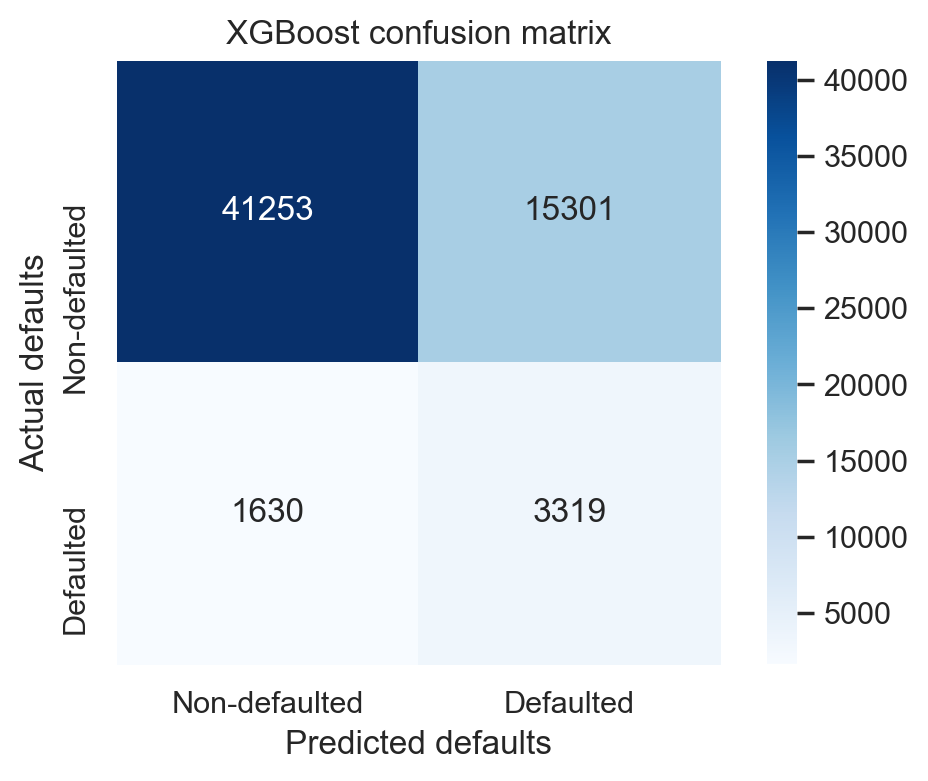

In [53]:
# Print confusion matrix for logistic regression
xgb_confusion = confusion_matrix(y_test, y_pred)
plt.figure(dpi=100)
sns.heatmap(xgb_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['Non-defaulted', 'Defaulted'],
           yticklabels=['Non-defaulted', 'Defaulted'])

plt.xlabel('Predicted defaults')
plt.ylabel('Actual defaults')
plt.title('XGBoost confusion matrix');

plt.savefig("confusion_matrix_xgb.png")

In [65]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict_proba = (model.predict_proba(X_test_poly)[:, 1] >= threshold)
    y_predict = model.predict(X_test_poly)
    default_confusion = confusion_matrix(y_test, y_predict_proba)
    plt.figure(dpi=100)
    sns.heatmap(default_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['Non-defaulted', 'Defaulted'],
           yticklabels=['Non-defaulted', 'Defaulted']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

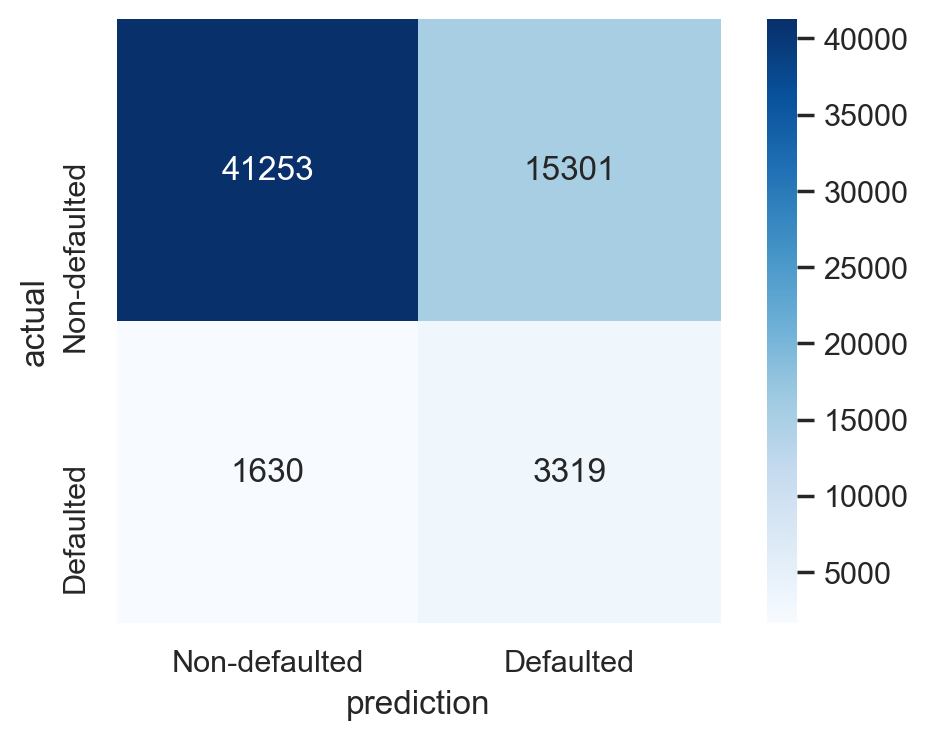

In [66]:
make_confusion_matrix(gbm)

In [67]:
# Let's see how our confusion matrix changes with changes to the cutoff! 

from ipywidgets import interactive, FloatSlider

interactive(lambda threshold: make_confusion_matrix(gbm, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [94]:
recall_score(y_test, y_pred)

0.6706405334410992

In [69]:
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_predict

In [ ]:
y_scores = g

In [102]:
precision_score(y_test, gbm.predict(X_test_poly))

0.17824919441460796

In [103]:
recall_score(y_test, gbm.predict(X_test_poly))

0.6706405334410992

In [104]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, gbm.predict(X_test_poly))

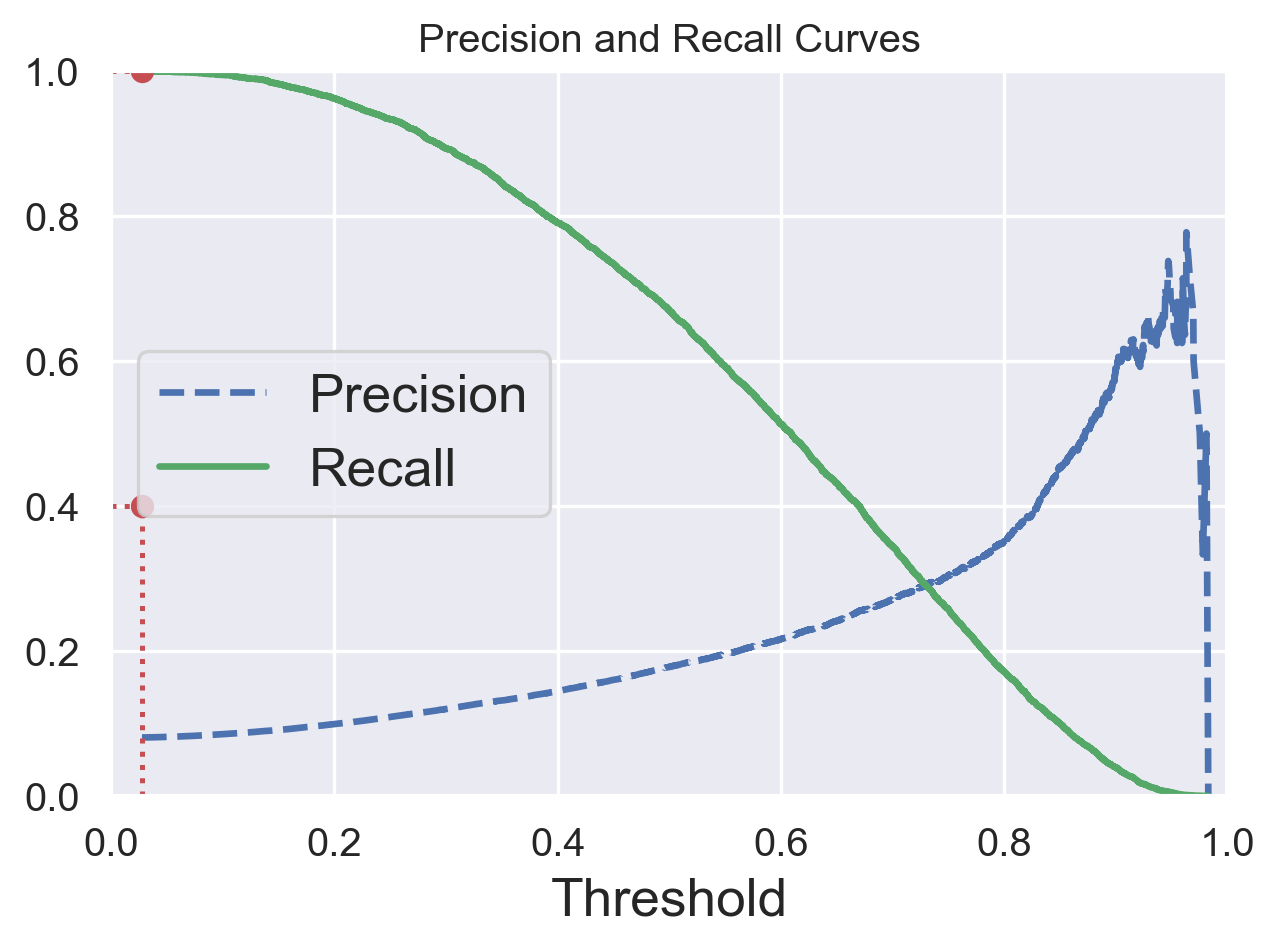

In [106]:
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, gbm.predict_proba(X_test_poly)[:,1] )


def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center left", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)                      
    plt.axis([0, 1, 0, 1])     

recall_40_precision = recall_curve[np.argmax(recall_curve >= 0.5)]
threshold_40_precision = threshold_curve[np.argmax(recall_curve >= 0.5)]

plt.figure(dpi=120)
plot_precision_recall_vs_threshold(precision_curve, recall_curve, threshold_curve)
plt.plot([threshold_40_precision, threshold_40_precision], [0., 0.4], "r:")                 
plt.plot([0, threshold_40_precision], [0.4, 0.4], "r:")                                
plt.plot([0, threshold_40_precision], [recall_40_precision, recall_40_precision], "r:")
plt.plot([threshold_40_precision], [0.4], "ro")                                             
plt.plot([threshold_40_precision], [recall_40_precision], "ro")  

plt.title('Precision and Recall Curves');

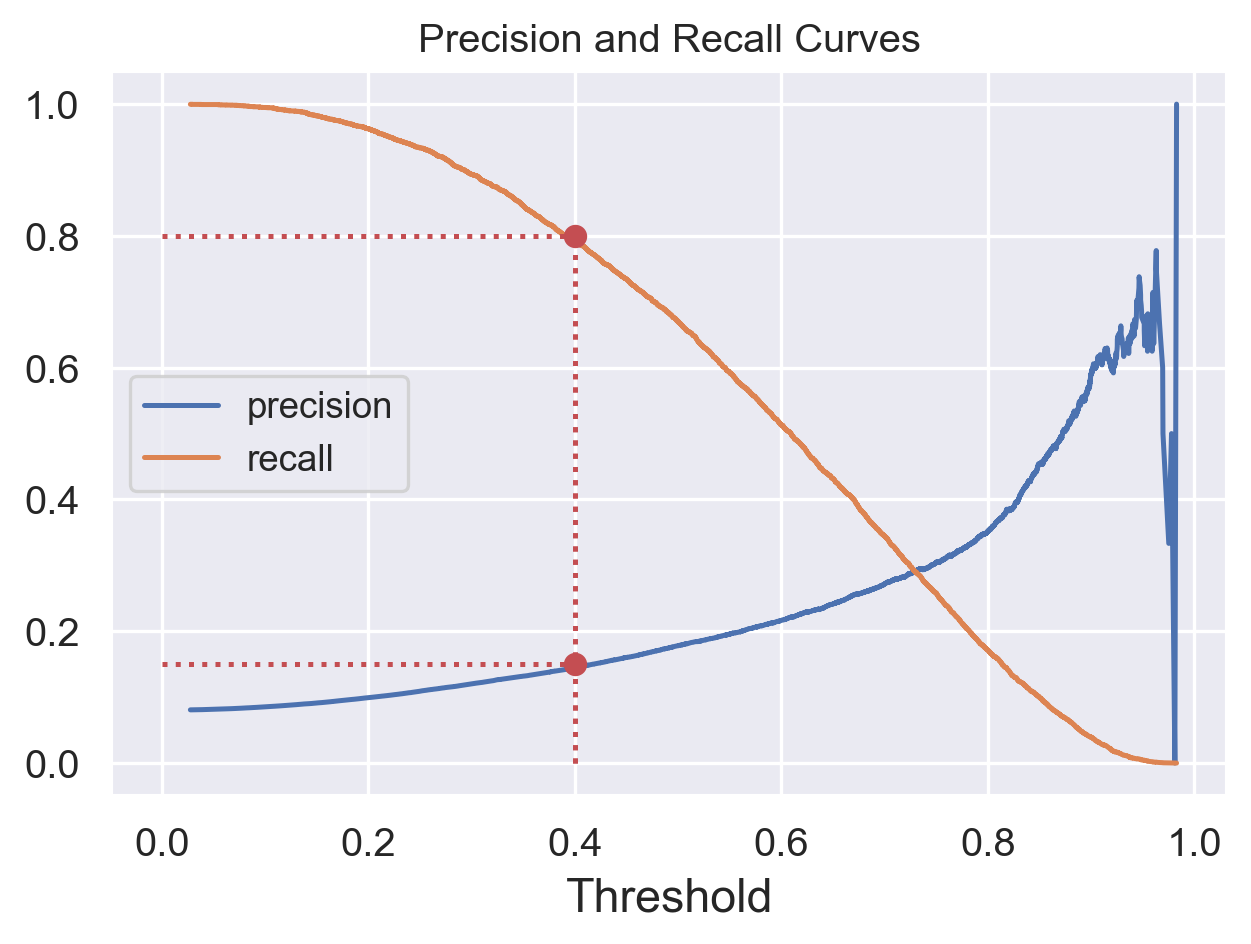

In [127]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, gbm.predict_proba(X_test_poly)[:,1] )

plt.figure(dpi=120)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')

plt.plot([0.4, 0.4], [0., 0.8], "r:")
plt.plot([0, 0.4], [0.8, 0.8], "r:")
plt.plot([0.4, 0.4], [0., 0.8], "r:")
plt.plot([0, 0.4], [0.15, 0.15], "r:")
plt.plot([0.4], [0.8], "ro")  
plt.plot([0.4], [0.15], "ro") 


plt.legend(loc='center left')
plt.xlabel('Threshold');
plt.title('Precision and Recall Curves');

In [19]:
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, gbm.predict_proba(X_test_poly, ntree_limit=gbm.best_ntree_limit)[:, 1])

### ROC Curve